<a href="https://colab.research.google.com/github/wafa-meddeb/Data-Science-Project-/blob/main/SBUX_Stock_Forecasting_with_LSTMs_stream2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('/content/data1.csv')

df

,date,open,high,low,close,adj_close,volume
0,"Nov 27, 2023",102.29,103.09,102.08,102.45,102.45,4132391.0
1,"Nov 24, 2023",103.44,103.60,102.47,102.78,102.78,3206400.0
2,"Nov 22, 2023",104.16,104.68,103.28,103.44,103.44,4828700.0
3,"Nov 21, 2023",104.45,104.68,103.17,103.69,103.69,6149000.0
4,"Nov 20, 2023",105.21,105.47,103.86,104.30,104.30,9799500.0
...,...,...,...,...,...,...,...
95,"Jul 17, 2023",100.83,101.81,100.04,100.93,99.85,5244500.0
96,"Jul 14, 2023",101.77,102.08,100.99,101.61,100.52,3934400.0
97,"Jul 13, 2023",101.51,102.20,101.30,101.60,100.51,4511700.0
98,"Jul 12, 2023",101.42,101.83,100.76,101.14,100.05,6971900.0


In [ ]:
nan_values = df.isna().sum()
nan_values

date         0
open         2
high         2
low          2
close        2
adj_close    2
volume       2
dtype: int64

In [ ]:
df.dropna(axis=0, how='any',inplace = True)

In [ ]:
df.isna().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

Text(0.5, 1.0, 'SBUX Daily Close Price')

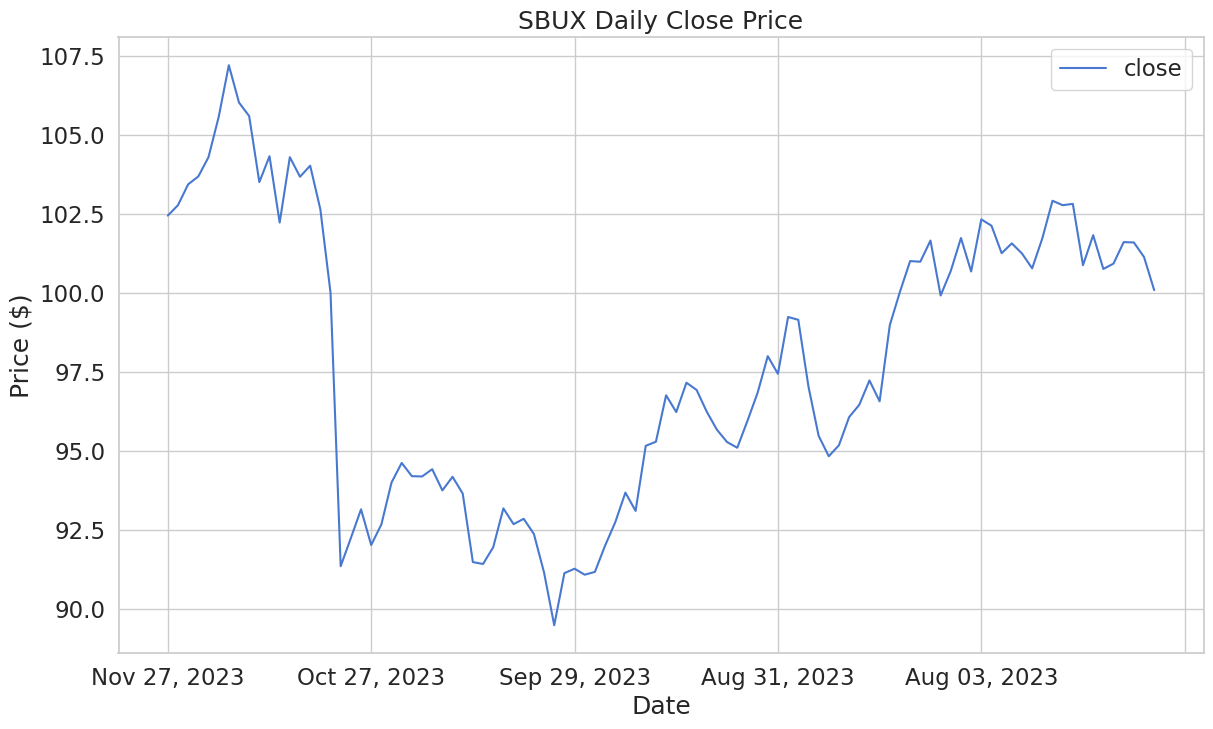

In [ ]:
%matplotlib inline
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

rcParams['figure.figsize'] = 14, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# data plot
ax = df.plot(x='date', y='close');
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('SBUX Daily Close Price')

In [ ]:
df = df[['date', 'close']]
df

,date,close
0,"Nov 27, 2023",102.45
1,"Nov 24, 2023",102.78
2,"Nov 22, 2023",103.44
3,"Nov 21, 2023",103.69
4,"Nov 20, 2023",104.30
...,...,...
95,"Jul 17, 2023",100.93
96,"Jul 14, 2023",101.61
97,"Jul 13, 2023",101.60
98,"Jul 12, 2023",101.14


In [ ]:
df['date']

0     Nov 27, 2023
1     Nov 24, 2023
2     Nov 22, 2023
3     Nov 21, 2023
4     Nov 20, 2023
          ...     
95    Jul 17, 2023
96    Jul 14, 2023
97    Jul 13, 2023
98    Jul 12, 2023
99    Jul 11, 2023
Name: date, Length: 98, dtype: object

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [ ]:
df

,date,close
0,"Nov 27, 2023",102.45
1,"Nov 24, 2023",102.78
2,"Nov 22, 2023",103.44
3,"Nov 21, 2023",103.69
4,"Nov 20, 2023",104.30
...,...,...
95,"Jul 17, 2023",100.93
96,"Jul 14, 2023",101.61
97,"Jul 13, 2023",101.60
98,"Jul 12, 2023",101.14


In [ ]:
df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])

<ipython-input-13-256829d529a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
<ipython-input-13-256829d529a9>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])


In [ ]:
df.index = df.pop('date')
df

,close
date,
2023-11-27,102.45
2023-11-24,102.78
2023-11-22,103.44
2023-11-21,103.69
2023-11-20,104.30
...,...
2023-07-17,100.93
2023-07-14,101.61
2023-07-13,101.60


In [ ]:
df = df.sort_values(by='date', ascending=True)
df


,close
date,
2023-07-11,100.09
2023-07-12,101.14
2023-07-13,101.60
2023-07-14,101.61
2023-07-17,100.93
...,...
2023-11-20,104.30
2023-11-21,103.69
2023-11-22,103.44


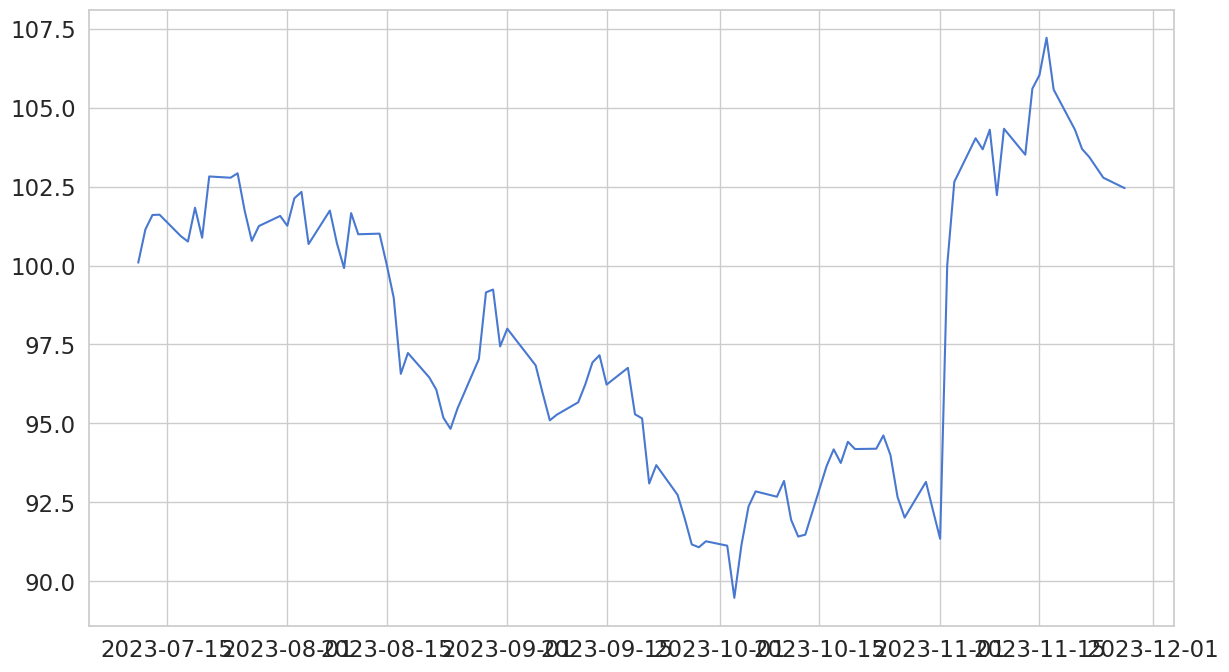

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['close'])

In [ ]:
import numpy as np
import pandas as pd
import datetime

def df_to_windowed_df(dataframe, target_date_str, *, n=7):
    def str_to_datetime(date_str):
        return datetime.datetime.strptime(date_str, "%Y-%m-%d")

    target_date = str_to_datetime(target_date_str)

    dates = []
    X, Y = [], []

    for i in range(n, len(dataframe)):
        start_index = i - n
        end_index = i

        if end_index >= len(dataframe):
            break

        values = dataframe.iloc[start_index:end_index + 1]['close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(dataframe.index[i])
        X.append(x)
        Y.append(y)

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    for i in range(n):
        ret_df[f'Past-{n-i}'] = [x[i] for x in X]

    ret_df['Target'] = Y

    return ret_df



In [ ]:
windowed_df = df_to_windowed_df(df, '2023-07-18', n=7)


In [ ]:
windowed_df

,Target Date,Past-7,Past-6,Past-5,Past-4,Past-3,Past-2,Past-1,Target
0,2023-07-20,100.09,101.14,101.60,101.61,100.93,100.76,101.83,100.88
1,2023-07-21,101.14,101.60,101.61,100.93,100.76,101.83,100.88,102.82
2,2023-07-24,101.60,101.61,100.93,100.76,101.83,100.88,102.82,102.78
3,2023-07-25,101.61,100.93,100.76,101.83,100.88,102.82,102.78,102.92
4,2023-07-26,100.93,100.76,101.83,100.88,102.82,102.78,102.92,101.73
...,...,...,...,...,...,...,...,...,...
86,2023-11-20,102.23,104.33,103.51,105.60,106.03,107.21,105.57,104.30
87,2023-11-21,104.33,103.51,105.60,106.03,107.21,105.57,104.30,103.69
88,2023-11-22,103.51,105.60,106.03,107.21,105.57,104.30,103.69,103.44
89,2023-11-24,105.60,106.03,107.21,105.57,104.30,103.69,103.44,102.78


In [ ]:
def windowed_df_to_date_X_y(windowed_df):
  df_as_np = windowed_df.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1 )) #1: because we are doing a forecasting for one variable

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32) #to fix an error

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape
#(85,7,1) we are looking for 7 steps in the back for only one variable "close"

((91,), (91, 7, 1), (91,))

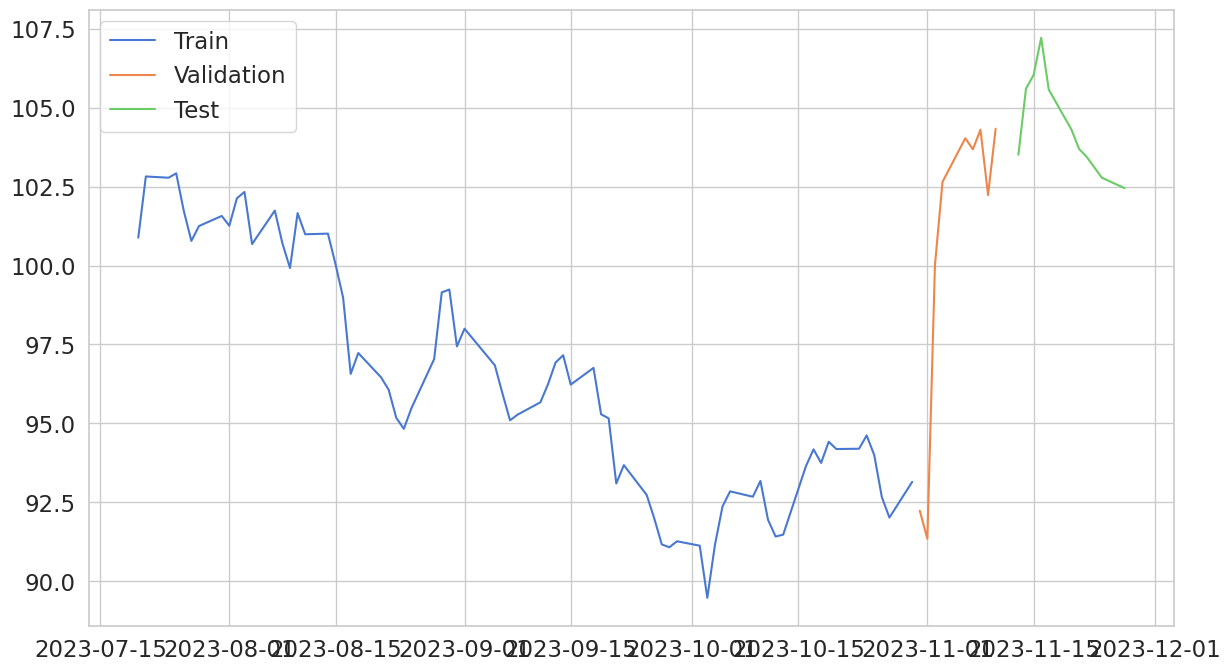

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming X_train, X_val, and y_train, y_val, X_test, y_test are your input features and target variables

# Create separate scalers for X (features) and y (target variable)
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Reshape y_train, y_val, and y_test if needed (MinMaxScaler expects 2D array)
y_train_reshaped = y_train.reshape(-1, 1)
y_val_reshaped = y_val.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Fit and transform y_train with the y_scaler
y_train_scaled = y_scaler.fit_transform(y_train_reshaped)

# Transform y_val with the y_scaler (using parameters learned from y_train)
y_val_scaled = y_scaler.transform(y_val_reshaped)

# Transform y_test with the y_scaler (using parameters learned from y_train)
y_test_scaled = y_scaler.transform(y_test_reshaped)

# Reshape X_train, X_val, and X_test if needed
num_samples_train, num_timesteps_train, num_features_train = X_train.shape
num_samples_val, num_timesteps_val, num_features_val = X_val.shape
num_samples_test, num_timesteps_test, num_features_test = X_test.shape

X_train_reshaped = X_train.reshape(num_samples_train, num_timesteps_train * num_features_train)
X_val_reshaped = X_val.reshape(num_samples_val, num_timesteps_val * num_features_val)
X_test_reshaped = X_test.reshape(num_samples_test, num_timesteps_test * num_features_test)

# Fit and transform X_train with the X_scaler
X_train_scaled = X_scaler.fit_transform(X_train_reshaped)

# Transform X_val with the X_scaler (using parameters learned from X_train)
X_val_scaled = X_scaler.transform(X_val_reshaped)

# Transform X_test with the X_scaler (using parameters learned from X_train)
X_test_scaled = X_scaler.transform(X_test_reshaped)




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    layers.Input((7, 1)),
    Bidirectional(layers.LSTM(64)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=100)

Epoch 1/100
3/3 [==============================] - 6s 644ms/step - loss: 0.3165 - mean_absolute_error: 0.4934 - val_loss: 0.6972 - val_mean_absolute_error: 0.7584
Epoch 2/100
3/3 [==============================] - 0s 40ms/step - loss: 0.2437 - mean_absolute_error: 0.4267 - val_loss: 0.6017 - val_mean_absolute_error: 0.6982
Epoch 3/100
3/3 [==============================] - 0s 26ms/step - loss: 0.1844 - mean_absolute_error: 0.3644 - val_loss: 0.5029 - val_mean_absolute_error: 0.6287
Epoch 4/100
3/3 [==============================] - 0s 35ms/step - loss: 0.1231 - mean_absolute_error: 0.2902 - val_loss: 0.3988 - val_mean_absolute_error: 0.5585
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 0.0697 - mean_absolute_error: 0.2118 - val_loss: 0.2914 - val_mean_absolute_error: 0.4903
Epoch 6/100
3/3 [==============================] - 0s 33ms/step - loss: 0.0315 - mean_absolute_error: 0.1431 - val_loss: 0.2001 - val_mean_absolute_error: 0.4153
Epoch 7/100
3/3 [==========

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 128)               33792     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 39009 (152.38 KB)
Trainable params: 39009 (152.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


3/3 [==============================] - 1s 5ms/step


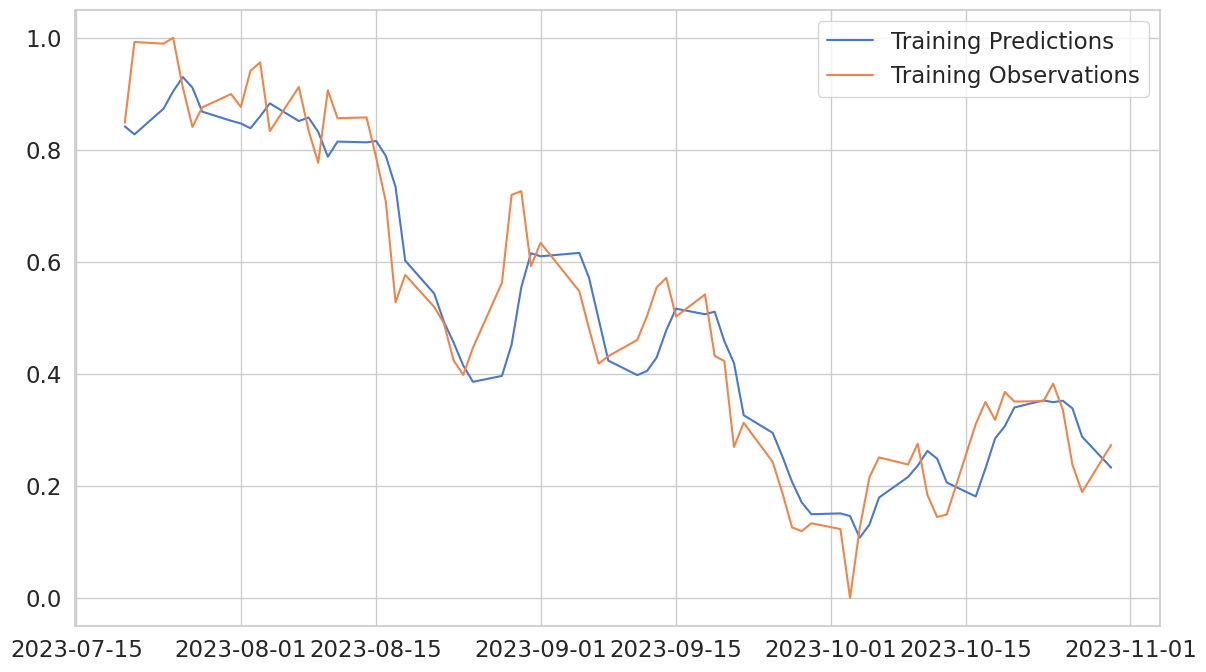

In [ ]:
train_predictions = model.predict(X_train_scaled).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train_scaled)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 28ms/step


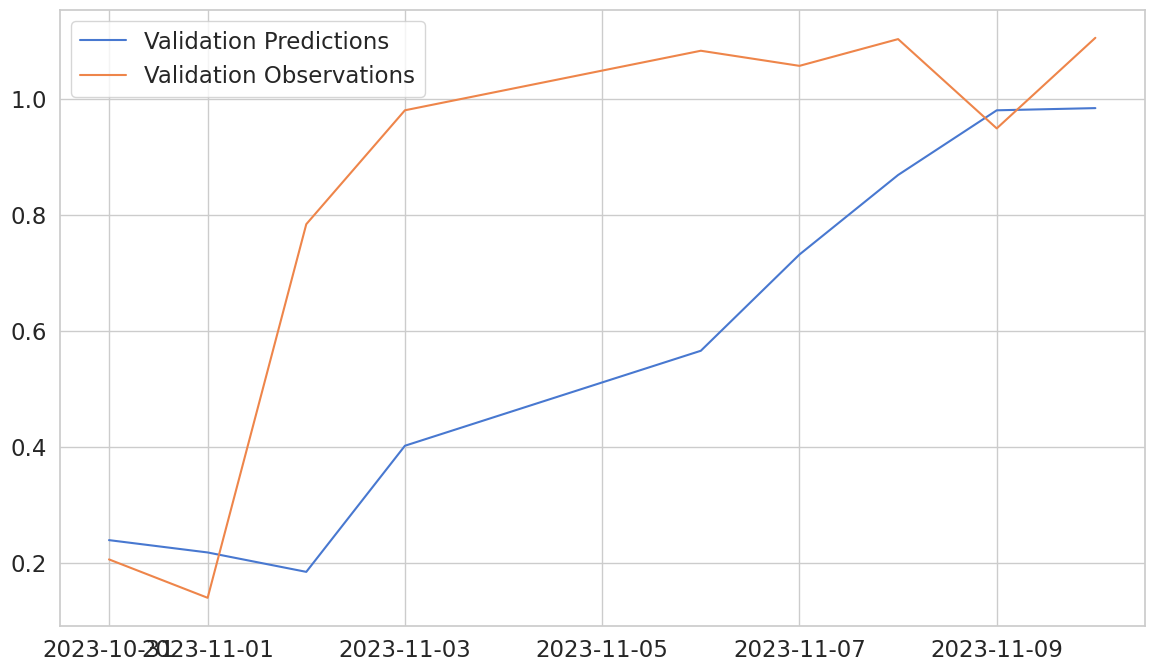

In [ ]:
val_predictions = model.predict(X_val_scaled).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val_scaled)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 30ms/step


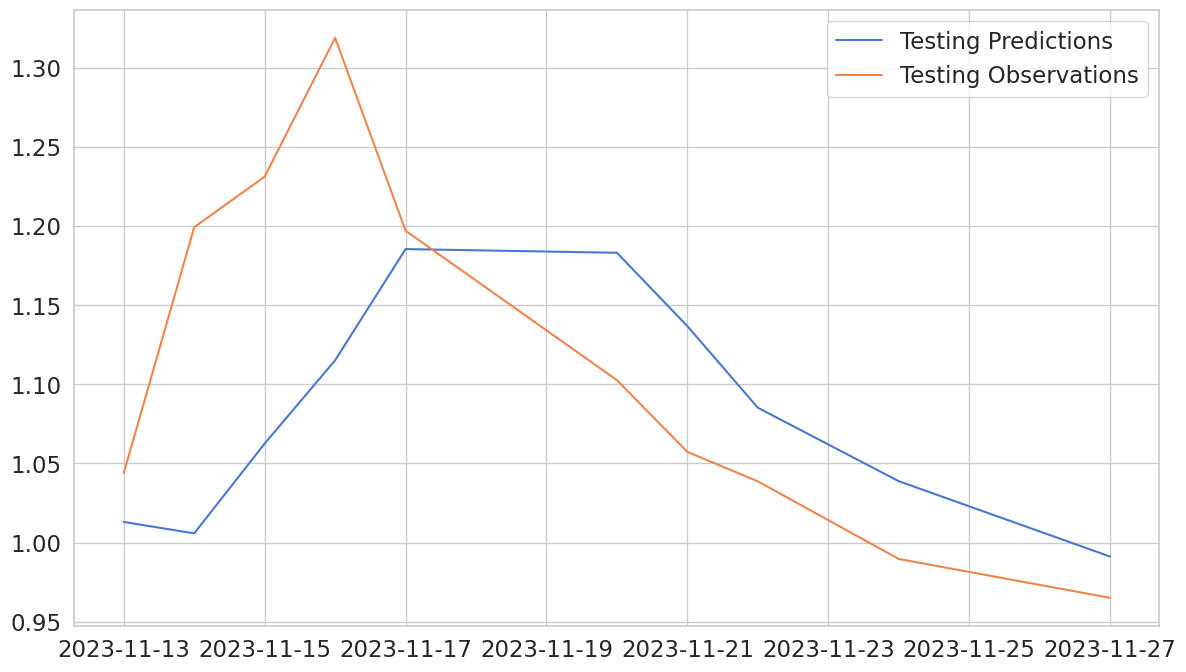

In [ ]:
test_predictions = model.predict(X_test_scaled).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test_scaled)
plt.legend(['Testing Predictions', 'Testing Observations'])

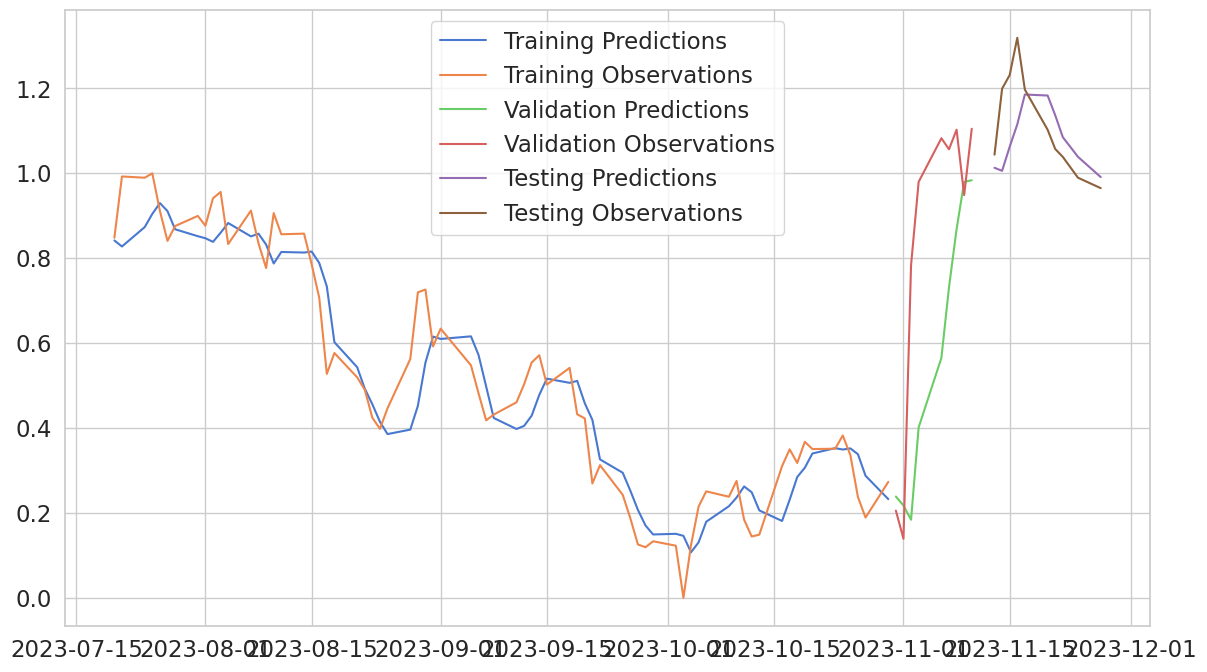

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train_scaled)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val_scaled)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test_scaled)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
'''
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train_scaled[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction
  '''

'\nfrom copy import deepcopy\n\nrecursive_predictions = []\nrecursive_dates = np.concatenate([dates_val, dates_test])\n\nfor target_date in recursive_dates:\n  last_window = deepcopy(X_train_scaled[-1])\n  next_prediction = model.predict(np.array([last_window])).flatten()\n  recursive_predictions.append(next_prediction)\n  last_window[-1] = next_prediction\n  '

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
last_window = deepcopy(X_test_scaled[-1])

for target_date in recursive_dates:
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction[0])
  last_window[:-1] = last_window[1:]
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 25ms/step


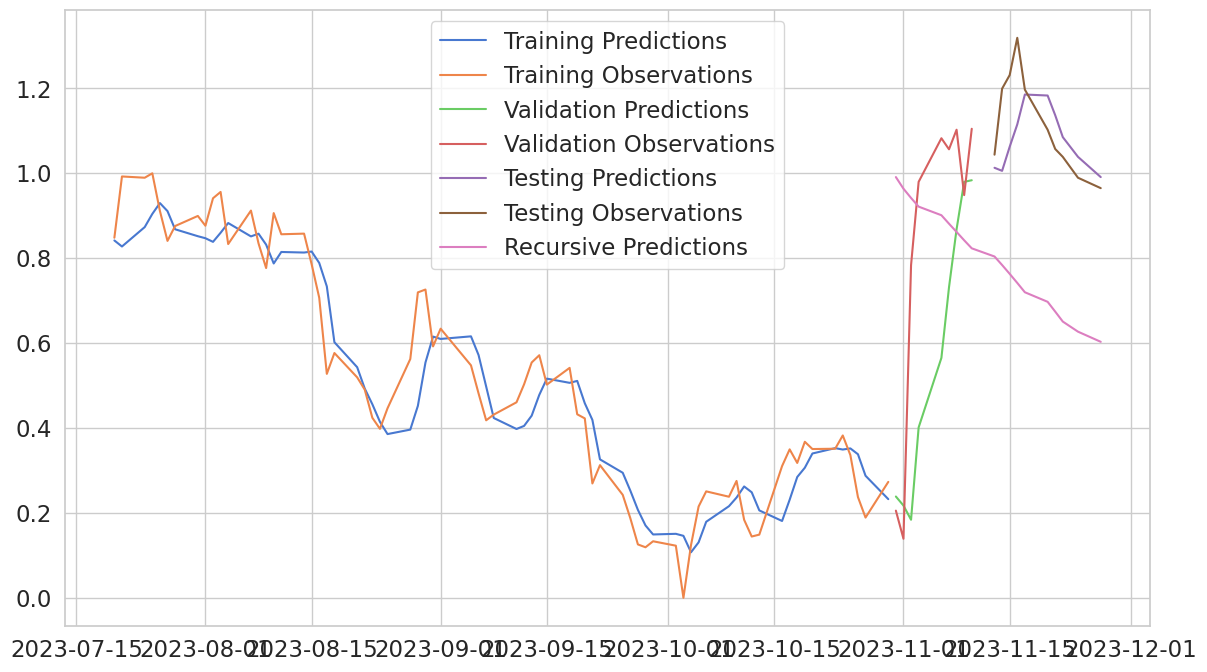

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train_scaled)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val_scaled)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test_scaled)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

In [ ]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

# Initialize last_window with the last training window
last_window = deepcopy(X_train_scaled[-1])

for target_date in recursive_dates:
    # Find the index corresponding to target_date in your dataframe
    target_index = np.where(df.index == target_date)[0][0]

    # Use the true value from the validation or test set
    true_value = df.loc[target_date, 'close']

    # Append true_value to recursive_predictions
    recursive_predictions.append(true_value)

    # Update last_window with the true value
    last_window[-1] = true_value

    # If you need to use the predicted value for the next iteration
     #Uncomment the following lines:
    #next_prediction = model.predict(np.array([last_window])).flatten()
    #recursive_predictions.append(next_prediction)
    #last_window[-1] = next_prediction


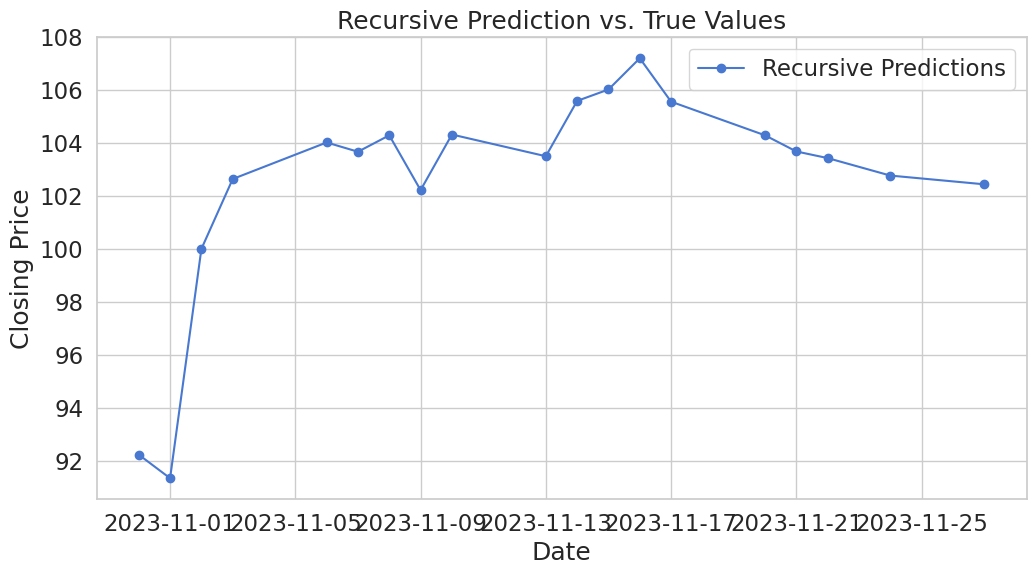

In [ ]:
import matplotlib.pyplot as plt

# Assuming recursive_dates and recursive_predictions are available
# If using the original dataframe:
true_values = [df.loc[date, 'close'] for date in recursive_dates]

# If using the windowed_df:
# true_values = windowed_df['Target'].values

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(recursive_dates, recursive_predictions, label='Recursive Predictions', marker='o')
# Uncomment the line below if using the original dataframe
# plt.plot(recursive_dates, true_values, label='True Values', marker='o', linestyle='--', color='green')
plt.title('Recursive Prediction vs. True Values')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()
